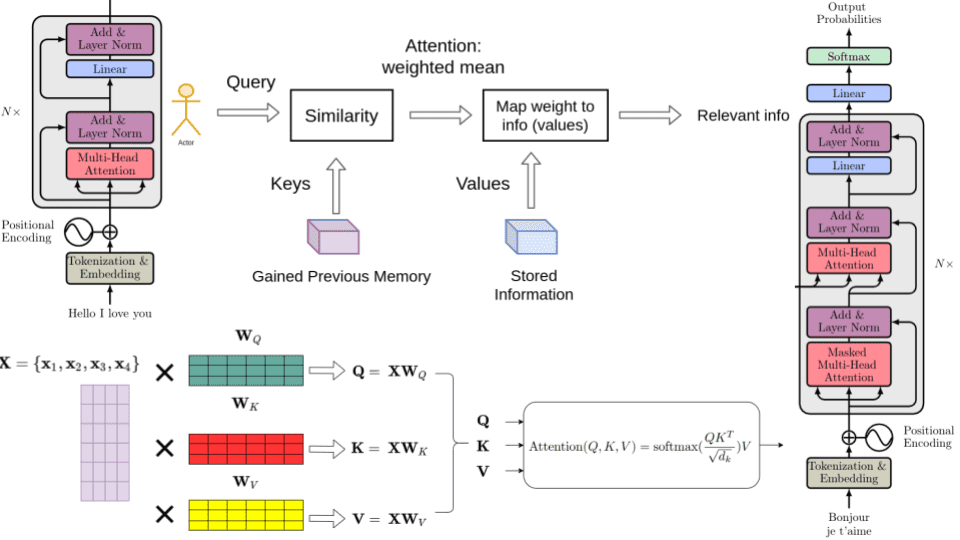

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, hidden_dim, d_model, drop_prob=0.1):
        super(PositionwiseFeedForward).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

  def forward(self, x):
    x = self.linear1(x) # 30 x 200 x 2048
    x = self.relu(x)
    x = self.dropout(x)
    x = self.linear2(x) # 30 x 200 x 512

    return x

In [ ]:
"""
Here we will basically utilise the encoder values learnt and just like cross attention will learn key and value from here and query will come from
self-attention unit of decoder because those are the word which I want to query and context is from encoder which will provide key and value
"""

class MultiHeadCrossAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model) # 1024 basically here we are dividing the encoder vectors into k and v of dimension 64 each
        self.q_layer = nn.Linear(d_model , d_model) # we get the q from the self attention vectors learnt from the self-attn in decoder
        self.linear_layer = nn.Linear(d_model, d_model) # just getting 512 dimension for feed forward network

    def forward(self, x, y, mask=None):
        batch_size, sequence_length, d_model = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")
        kv = self.kv_layer(x) # 30 x 200 x 1024 From the encoder (in self-attn this used to be 1536 because we get q,k,v from same input)
        print(f"kv.size(): {kv.size()}")
        q = self.q_layer(y) # 30 x 200 x 512 # getting the q vector from self-attn decoder
        print(f"q.size(): {q.size()}")
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)  # 30 x 200 x 8 x 128
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)  # 30 x 200 x 8 x 64
        kv = kv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 128
        q = q.permute(0, 2, 1, 3) # 30 x 8 x 200 x 64
        k, v = kv.chunk(2, dim=-1) # K: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64

        """
        Here we don't basically do
        masking but it's necessary if sequences are
        of variable length and padded then for padding
        tokens they should be masked
        """
        values, attention = scaled_dot_product(q, k, v, mask) # 30 x 8 x 200 x 64
        print(f"values: {values.size()}, attention:{attention.size()}")
        values = values.reshape(batch_size, sequence_length, d_model) #  30 x 200 x 512
        out = self.linear_layer(values)  #  30 x 200 x 512
        print(f"out after passing through linear layer: {out.size()}")
        return out  #  30 x 200 x 512



In [ ]:
"""
Why we want layer normalization???
We do it so that for each layer constraining the value with mean 0 and std~1 ,
the jumps that happens in gradient decent are stable and not affected by sparsity
"""
class LayerNormalization(nn.Module):
  def __init__(self, parameters_shape, eps = 1e-5):
    super().__init__()
    self.parameters_shape = parameters_shape
    self.eps = eps
    self.gamma = nn.Parameter(torch.ones(parameters_shape)) # [512] this is for std
    self.beta = nn.Parameter(torch.ones(parameters_shape)) # [512] this is for mean

  def forward(self, inputs): # here inputs is residual + output from attention either self or cross 30x200x512

    dims = [-(i+1) for i in range(len(self.parameters_shape))] # so basically along the 512 dimension where actual values for each word is there

    mean = inputs.mean(dim=dims, keepdim=True) # taking the mean of all 512 dimensional vector and we keepdim = True because else it will give 30x200 vector but we want 30x200x1

    var = ((inputs-mean) **2).mean(dim=dims, keepdim=True) # calculating the variance 30 x 200 x 512

    std = (var + self.eps).sqrt() # 30 x 200 x 512

    y = (inputs - mean)/std # this is normalization

    out = self.gamma * y + self.beta # these are learnable params they are all initialised to  gamma = ones and  beta = zeros, we have them for each specific word in

    return out # 30 x 200 x 512


In [ ]:
# Multi Head attention 1st technical breakdown
# Every single word is broken down into three vectors q, k, v . query vector q is like what I am looking for, k is what I have and v is what I offer from attention

def scaled_dot_product(q, k, v, mask=None): # This is basically attention for one head
  d_k = k.size()[-1] # get the dimension of k vector to normalize the scaled dot product in the attention. d_k is 64 for each head

  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # k is not for one word but for all words in the sentence and for all sentences in a  i.e k.transpose will give [batch_size, d_model, max_seq_length]
  # scaled is max_seq_length x max_seq_length dimension along with the batch. The normalization allows values in attention matrix to be close like mean 0 and std ~1 to have stable steps during backpropogation.

  # mask is required in decoder as we generate words in regressive manner hence we don't want to look into future to get the context it will be cheating.
  if mask is not None:
    scaled += mask # broadcasting as we are adding two different tensors of different dimension

  attention = F.softmax(scaled, dim=-1) # dim =-1 because attention values are stored in the last dimension of the scaled. This will make attention probabilities determining how much one word focuses on the other
  values = torch.matmul(attention, v) # this will give new set of values for each word. This value vector for the word basically has the context of how much to attend to other words

  return values, attention


class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads # this is basically 512/8 = 64 i.e dimension of k,q v for each head
    self.qkv_layer = nn.Linear(d_model, 3*d_model) # It basically contains qkv for all attention heads and hence 3 * 512 as 512 alone contains qkv of 8 heads each of dimension 64
    self.linear_layer = nn.Linear(d_model, d_model)


  def forward(self, x, mask=None):
    batch_size, sequence_lenght, d_model = x.size()
    qkv = self.qkv_layer(x) # this will basically gives qkv for each word in all 8 heads of attention
    qkv = qkv.reshape(batch_size, sequence_length, self.num_head, 3* self.head_dim) # here we have broken down the last dimension 3*d_model of qkv_layer into heads and 3 * 64 each for q, k and v
    qkv = qkv.permute(0, 2, 1, 3) # we now make it [batch_size, heads, sequence_length, 3*head_dim] 30  x 8 x 200 x 192
    q, k, v = qkv.chunk(3, dim=-1) # this will help us get qkv of all heads by chunking the last dimension  each of the q k and v will have dimension [batch_size, heads, max_Seq_length, head_dim]  30 x 8 x 200 x 64
    values , attention = scaled_dot_product(q, k, v, mask) # attention will have dimension [batch_size, 8 , 200, 200] and values will have [batch_size, heads, max_seq_length, 64 ]
    values = values.reshape(batch_size, sequence_length, self.num_heads*self.head_dim ) # 30 x 200 x 512 rearranging back to original tensor shape
    out = self.linear_layer(values) # 30 x 200 x 512

    return out # returned to Encoder Layer


In [ ]:
# Let's take a look at each decoder layer

class DecoderLayer(nn.Module):
  def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
      self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
      self.norm1 = LayerNormalization(parameters_shape = [d_model])
      self.dropout1 = nn.Dropout(p=drop_prob)
      self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
      self.norm2 = LayerNormalization(parameters_shape = [d_model])
      self.dropout2 = nn.Dropout(p=drop_prob)
      self.ffn = PositionWiseFeedForward(d_model = d_nodel, hidden = ffn_hidden, drop_prob = drop_prob)
      self.norm3 = LayerNormalization(parameters_shape = [d_model])
      self.dropout3 = nn.Dropout(p=drop_prob)

  def forward(x,y,decoder_mask):
    residual_connection = y
    print("Masked Self attention")
    y = self.self_attention(y, mask = decoder_mask) # 30 x 200 x 512
    print("Dropout 1")
    y = self.dropout1(y)
    # this is basically add and layer norm after performing self attetnion in the decoder side
    y = self.norm1(y + res)

    # remember now we do cross attention in decoder and keep the self attention output as residual to use it after cross attn for add and layer norm

    residual_connection = y
    # cross attention we don't pass any mask
    y = slef.encoder_decoder_attention(x, y)
    y = self.dropout2(y)
    # now againg add  and norm
    y = self.norm2(y + residual_connection)

    #again keep residual for using it after feed forward layer
    residual_connection = y

    y = ffn(y) # 30 x 200 x 512

    y = self.dropout3(y)

    y = self.norm3(y + residual_connection)

    return y # 30 x 200 x 512


In [ ]:
# https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html See how extending this class we are able to pass multiple values
class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
      x, y, mask = inputs
      """
      We have 5 layers of decoder, so in each layer of decoder we are passing the output y i.e kannada back to the next decoder layer and we paas
      i.e output from the encoder as it is in every decoder layer. This is just to maintain the sequential stacking and passing of outputs from one
      decoder layer to another
      """
      for module in self._modules.values():
        y = module(x,y,mask) # after one decoder layer it will have 30 x 200 x 512 dimension tensor is there is passed back to next layer

      return y # once all the layers is done we will get the final tensor 30 x 200 x 512



In [ ]:
class Decoder(nn.Module):
  def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
    super().__init__()
    # If we only use the nn.Sequential we can only pass one parameter input into it as done in encoder but here in decoder we want to pass x, y and mask in the forward.
    self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob)] for _ in range(num_layers))

  def forward(x, y, mask):
    # x -> english, y -> kannada sentence , mask
    y = self.layers(x,y, mask) # x: 30 x 200 x 512, y: 30 x 200 x 512, mask = 200 x 200

    # on this y then we use linear layer and softmax to get the next words  by putting a softmax over it

    y = nn.Linear(y, target_language_vocab_size) # target_language_vocab_size = 61 if codons in DNA or RNA sequence i.e 30 x 200 x 61
    y = F.softmax(y, dim = -1) # 30 x 200 i.e at each position in target sentence it will get the most probable word over there

    return y  # return the final output

In [ ]:
 # define the hyper-prarameters
 d_model = 512 # each word in entire transformer is represented as 512 dimensional vector
 num_heads = 8 # It determines the number of times we want to perform self-attention  and cross attention
 drop_prob = 0.1
 batch_size = 30 # allows multiple processing for faster training
 max_sequence_length = 200 # the length of max sequence
 ffn_hidden = 2048 # hidden layers in FFN network after attention
 num_layers = 5 # the number of encoder and decoder layers we require in repetition they are cascaded or stacked on top of each other


 x = torch.randn((batch_size, max_sequence_length, d_model)) # It's an input of english language which we have received from the encoder
 y =  torch.randn((batch_size, max_sequence_length, d_model)) # It's the target language after poisitional encoding is done 512 dimension vector

 mask = torch.full([max_sequence_length, max_sequence_length], float('-inf')) # seq_length x seq_length because we want to mask attention values
 mask = torch.triu(mask, diagonal=1) # how much far sway from diagonal we want to start our upper triangular matrix of -inf kind of for avoiding look ahead

 decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
 out = decoder(x, y, mask)